<h1> Cat vs Dog Image Classifier </h1>

<p> I am creating this project to attempt to use Deep Learning to create a model that can accurately predict whether an image has a cat or dog. </p>

In [29]:
import tensorflow as tf 
import os

<h3> Data Preprocessing and Loading </h3>

<h4> Checking for Problematic Images </h4>

I am using OpenCV to read the images in the dataset. If any issues occur while reading an image, such as an unreadable or corrupted file, it prints a message indicating the problem and removes the problematic image from the directory. 

Also, in this case the dataset which I am using only has images in the JPEG format. If the images were not standardised I would have to also have to check the format of the images and remove some, such as those that were not in jpeg or png. 

In [30]:
import cv2
data_dir = 'dataset'

for directory in os.listdir(data_dir): #directory refers to the train and test folders
    if directory != ".DS_Store": #kept getting not a directory error
        for image_class in os.listdir(os.path.join(data_dir,directory)): #image class refers to the directories of dogs and cats
            image_class_dir = os.path.join(data_dir, directory, image_class)
            if not os.path.isdir(image_class_dir):
                continue

            for image in os.listdir(image_class_dir):
                image_path = os.path.join(image_class_dir, image)
                try:
                    img = cv2.imread(image_path)
                    if img is None:
                        raise Exception("Failed to read image")
                except Exception as e:
                    print(f"Issue with image {image_path}: {str(e)}")
                    os.remove(image_path)


In [31]:
#tf.data.Dataset??

In [32]:
import numpy as np
from matplotlib import pyplot as plt

<h4> Loading the Data </h4>

<p> The function image_dataset_from_directory automatically does the image preprocessing for us. It resizes the images so they all have a default size of (256, 256). It also shuffles the images and splits them into batches of 32 images each. </p>

In [33]:
#tf.keras.utils.image_dataset_from_directory??
training_data = tf.keras.utils.image_dataset_from_directory('dataset/train')
testing_data = tf.keras.utils.image_dataset_from_directory('dataset/test')

Found 557 files belonging to 2 classes.
Found 140 files belonging to 2 classes.


In [34]:
#training_data doesnt store data but generates it. To iterate over data, I have to convert it into a NumPy array first 
data_iterator = training_data.as_numpy_iterator()

batch = data_iterator.next()

print(len(batch)) 
#returns 2 because the first value is the array of images and the second value is the array of labels (ie. cat or dog)

print(batch[0].shape) #32 images, each 256x256, 3 to represent rgb
print(batch[1].shape) #32 labels

#print(data_iterator.next())


2
(32, 256, 256, 3)
(32,)


<br>

The code below shows that dogs are labelled as 1 and cats are labelled as 0 

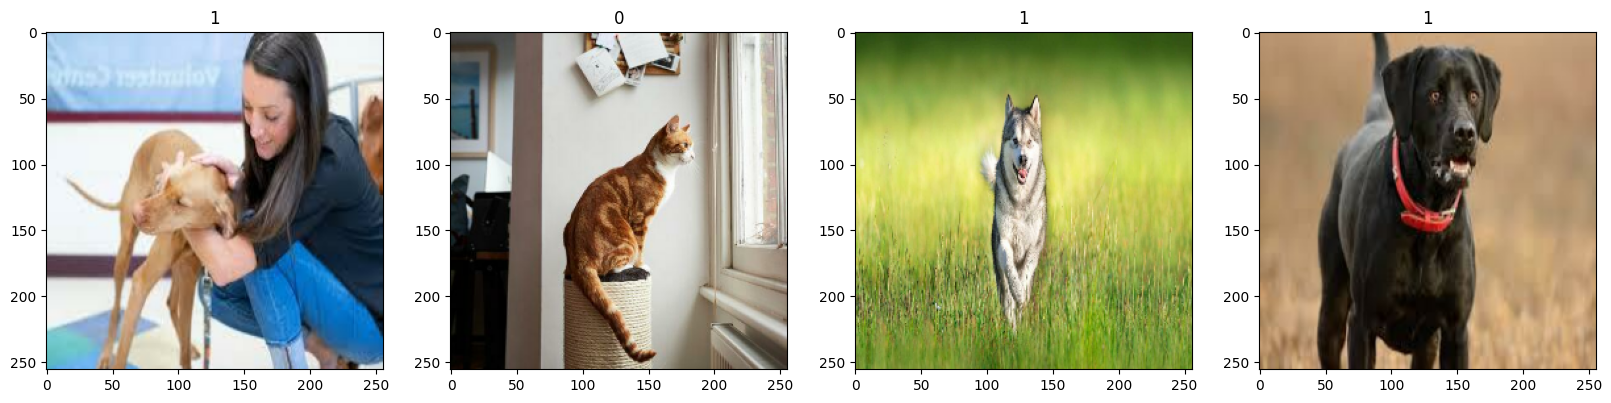

In [35]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])


<h4> Apply transformation as the data is being preprocessed through the pipeline. Data will be transformed when it is prefetched </h4>
<br>
Normalizing image data by dividing the pixel values by 255 and scaling them between 0 and 1. Normalization helps prevent any single feature, in this case, the pixel intensity, from dominating the learning process and affecting the model's performance. Secondly, normalization improves the stability and efficiency of optimization algorithms during model training. 

In [36]:
training_data = training_data.map(lambda x,y: (x/255, y))
testing_data = testing_data.map(lambda x,y: (x/255, y))
print(training_data.as_numpy_iterator().next()[0].max())
print(training_data.as_numpy_iterator().next()[0].min())

1.0
0.0


<h4> Splitting training data into training and validation. Validation will test the data as it's being trained </h4>

In [37]:
import math
training_size = math.floor(len(training_data)*.85)
validation_size = math.ceil(len(training_data)*.15)

In [38]:
training = training_data.take(training_size)
validation = training_data.skip(training_size).take(validation_size)

<h3>Creating and Training the Neural Network</h3>

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [70]:
model = Sequential()

#16 filters, each filter is 3x3 pixels, will move 1 pixel at a time.
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
#condenses the information by taking the max value in each grid
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Each filter generates a 2D feature map. When using multiple filters, the outputs of each 
# filter stack together to form a 3D volume. Hence, I need to flatten it as the Dense layer
# expects a 1D array
model.add(Flatten())

#fully connected layers for feature extraction
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

#Using sigmoid for final layer because output needs to be between 0 and 1 (binary classification)
model.add(Dense(1, activation='sigmoid')) 

In [71]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [72]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])


In [73]:
%%capture

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(training, epochs=50, validation_data=validation, callbacks=[tensorboard_callback])

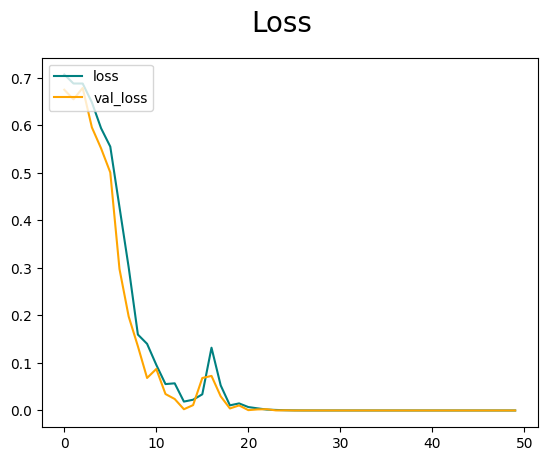

In [74]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

<h3> Evaluating the Model </h3>

In [75]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [76]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [77]:
%%capture

for batch in testing_data.as_numpy_iterator():
    X, y = batch
    predictions = model.predict(X)
    precision.update_state(y, predictions)
    recall.update_state(y, predictions)
    accuracy.update_state(y, predictions)

In [84]:
print(f"Preicison: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}")

Preicison: 0.6567164063453674, Recall: 0.6285714507102966, Accuracy: 0.6499999761581421


<h3> Testing with pictures found online </h3>

In [79]:
dog_test = cv2.imread('dog_test.jpeg')
dog_resize = tf.image.resize(dog_test, (256,256))

In [80]:
cat_test = cv2.imread('cat_test.jpeg')
cat_resize = tf.image.resize(cat_test, (256,256))


In [81]:
cat_prediction = model.predict(np.expand_dims(cat_resize/255, 0))[0][0]

dog_prediction = model.predict(np.expand_dims(dog_resize/255, 0))[0][0]

def cat_or_dog(prediction):
    if prediction > 0.5:
        return "This is a dog"
    else:
        return "This is a cat"

1/1 [==============================] - 0s 12ms/step


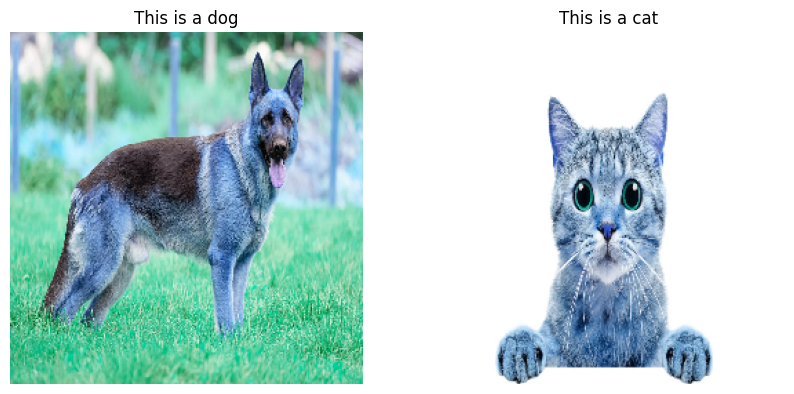

In [82]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(dog_resize.numpy().astype(int))
ax1.title.set_text(cat_or_dog(dog_prediction))
ax1.axis('off')

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(cat_resize.numpy().astype(int))
ax2.title.set_text(cat_or_dog(cat_prediction))
ax2.axis('off')

plt.show()

In [83]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models','imageclassifier.h5'))